In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
from prettytable import PrettyTable
from tqdm import tqdm_notebook

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [2]:
#this CSV file contains clean data
data = pd.read_csv('./Lahore-clean-data.csv')
data.index = pd.DatetimeIndex(data.Date_)
data = data.sort_index()

In [3]:
print('Range of dates: {} to {}'.format(data.Date_.min(), data.Date_.max()))

Range of dates: 01/01/2013 0:00 to 31/12/2015 0:00


In [4]:
data['Date_']=pd.to_datetime(data['Date_'])

In [5]:
data['Year'] = data.index.year
data['Month'] = data.index.month
data['dayOfWeek'] = data.index.dayofweek
data['dayOfMonth'] = data.index.day
data['dayOfYear'] = data.index.dayofyear

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [7]:
data_tr = data.loc['2013-01-01':'2013-12-31']
data_test = data.loc['2014-01-01':'2014-12-31']

In [8]:
listOfDist = list(data['Town_Name'].unique())
listOfDist

['Iqbal Town',
 'Samanabad Town',
 'Gulberg Town',
 'Data Gunj Bakhsh Town',
 'Nishtar Town',
 'Ravi Town',
 'Shalamar Town',
 'Cantonment',
 'Wahga Town',
 'Aziz Bhatti Town']

In [9]:
train_d = []
df = data_tr[data_tr['Town_Name'] == 'Iqbal Town']
df_gr = df.groupby(['Year', 'Month']).count()
train_d.append(list(df_gr['Date_'].values))

In [10]:
test_d = []
df = data_test[data_test['Town_Name'] == 'Iqbal Town']
df_gr = df.groupby(['Month']).count()
test_d.append(list(df_gr['Date_'].values))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Town: 1
Actuals: [900, 740, 812, 793, 806, 795, 847, 737, 842, 863, 945, 771]
Predictions: [889.7399, 1192.5167, 1006.38586, 633.6195, 1215.1173, 935.5739, 794.5526, 829.5236, 745.0119, 877.7638, 858.0133, 929.1368]


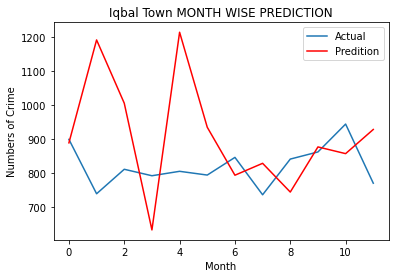

R-squared: -11.003
Mean Absolute Error:155.673
Median Absolute Error:118.781
Mean Squared Error:205.895


In [11]:
# prepare situation
window = 3
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # fit model
        model.fit(X, y, epochs=200, verbose=0)
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, window, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
    
    preds_new = [i[0] for i in preds]
    print('Town: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds_new))
    
    # plot
    plt.plot(test)
    plt.plot(preds_new, color='red')
    plt.title('Iqbal Town MONTH WISE PREDICTION')
    plt.xlabel("Month")
    plt.ylabel("Numbers of Crime")
    plt.legend(["Actual", "Predition"])
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds_new
    
print('R-squared: %.3f' %r2_score(testTot, predTot))
print('Mean Absolute Error:%.3f'%mean_absolute_error(testTot, predTot))
print('Median Absolute Error:%.3f'%median_absolute_error(testTot, predTot))
print('Mean Squared Error:%.3f'%mean_squared_error(testTot, predTot) ** .5)

In [12]:
test_d = []
df = data_test[data_test['Town_Name'] == 'Nishtar Town']
df_gr = df.groupby(['Month']).count()
test_d.append(list(df_gr['Date_'].values))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Town: 1
Actuals: [450, 461, 445, 440, 475, 362, 379, 400, 406, 443, 395, 371]
Predictions: [445.7823, 477.51215, 636.24207, 500.73666, 491.25848, 511.52774, 474.2443, 204.8216, 480.82916, 479.7361, 500.59464, 475.32852]


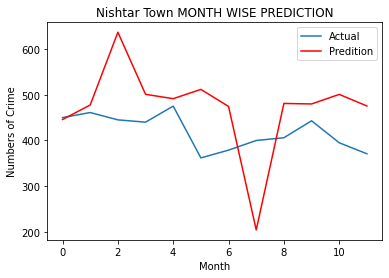

R-squared: -7.811
Mean Absolute Error:87.534
Median Absolute Error:85.037
Mean Squared Error:107.752


In [14]:
# prepare situation
window = 3
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, window, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
    
    preds_new = [i[0] for i in preds]
    print('Town: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds_new))
    
    # plot
    plt.plot(test)
    plt.plot(preds_new, color='red')
    plt.title('Nishtar Town MONTH WISE PREDICTION')
    plt.xlabel("Month")
    plt.ylabel("Numbers of Crime")
    plt.legend(["Actual", "Predition"])
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds_new

print('R-squared: %.3f' %r2_score(testTot, predTot))
print('Mean Absolute Error:%.3f'%mean_absolute_error(testTot, predTot))
print('Median Absolute Error:%.3f'%median_absolute_error(testTot, predTot))
print('Mean Squared Error:%.3f'%mean_squared_error(testTot, predTot) ** .5)